# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

##### Confounding variable - variables that aren't in data set that might affect our results

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_os',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=561.7915606110845, mobile=False), User(purchased=False, time_on_site=224.24025968715443, mobile=False), User(purchased=False, time_on_site=135.93733374496395, mobile=False), User(purchased=False, time_on_site=177.85983861601008, mobile=True), User(purchased=False, time_on_site=57.51410502412592, mobile=True), User(purchased=False, time_on_site=222.8524974416435, mobile=True), User(purchased=True, time_on_site=238.96139743529338, mobile=True), User(purchased=False, time_on_site=243.4467821950154, mobile=False), User(purchased=False, time_on_site=220.13888627050352, mobile=True), User(purchased=False, time_on_site=115.77941562060573, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,561.791561,False
1,False,224.240260,False
2,False,135.937334,False
3,False,177.859839,True
4,False,57.514105,True


Crosstab usually used for categorical variable 

In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.365377533715841,5.403818897568959,5.780115212117693,5.857548317344267,6.306205206608999,6.658671951279279,6.7195415189294945,7.013984355731228,7.253491320895394,7.2875897778653815,...,561.7915606110845,566.9242928251992,571.748134227504,576.6213156953761,576.6262509783572,580.6363913001605,588.9691495711913,589.3596114070488,589.8318294665181,592.7796540751358
purchased,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,0,1,0,1,1,0,1,...,0,0,1,1,1,0,0,0,0,1
True,1,0,0,1,0,1,0,0,1,0,...,1,1,0,0,0,1,1,1,1,0


In [9]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.778, 122.848]","(122.848, 240.331]","(240.331, 357.814]","(357.814, 475.297]","(475.297, 592.78]"
purchased,,,,,
False,245,211,119,19,21
True,132,130,86,19,18


In [10]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.778, 122.848]","(122.848, 240.331]","(240.331, 357.814]","(357.814, 475.297]","(475.297, 592.78]"
purchased,,,,,
False,0.649867,0.618768,0.580488,0.5,0.538462
True,0.350133,0.381232,0.419512,0.5,0.461538


In [12]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')


mobile,False,True
purchased,,
False,0.732,0.576
True,0.268,0.424


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [1]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [148]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [149]:
df = pd.read_csv('/Users/ridleyleisy/Documents/lambda/unit_one/DS-Unit-1-Sprint-1-Dealing-With-Data/module4-databackedassertions/persons.csv')

In [150]:
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [151]:
df.describe()

,Unnamed: 0,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
Unnamed: 0       1200 non-null int64
age              1200 non-null int64
weight           1200 non-null int64
exercise_time    1200 non-null int64
dtypes: int64(4)
memory usage: 37.6 KB


In [153]:
# taking a quick glance at correlations
df.corr()

,Unnamed: 0,age,weight,exercise_time
Unnamed: 0,1.000000,-0.000418,-0.060297,-0.020138
age,-0.000418,1.000000,0.144168,-0.273818
weight,-0.060297,0.144168,1.000000,-0.478021
exercise_time,-0.020138,-0.273818,-0.478021,1.000000


In [168]:
#binning ages into 5 sections
df['bin_age'] = pd.cut(df['age'], 5)

In [169]:
#dividing population into "old" and "young" based on the age of 50
older_pop = df.loc[df['age'] >= 50]
younger_pop = df[df['age'] < 50]

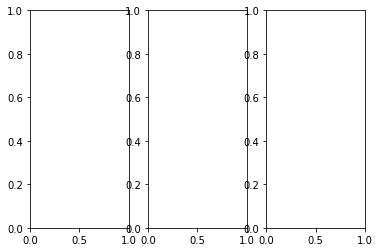

In [170]:
#creating subplot for seaborn 
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3)

In [171]:
#setting figure dimensions to fit in notebook
fig.set_figheight(5)
fig.set_figwidth(15)

In [172]:
#plotting distribution of weight based on total pop, young pop, and old pop
sns.distplot(df['weight'], ax=ax1)
sns.distplot(younger_pop['weight'], ax=ax2)
sns.distplot(older_pop['weight'], ax=ax3)

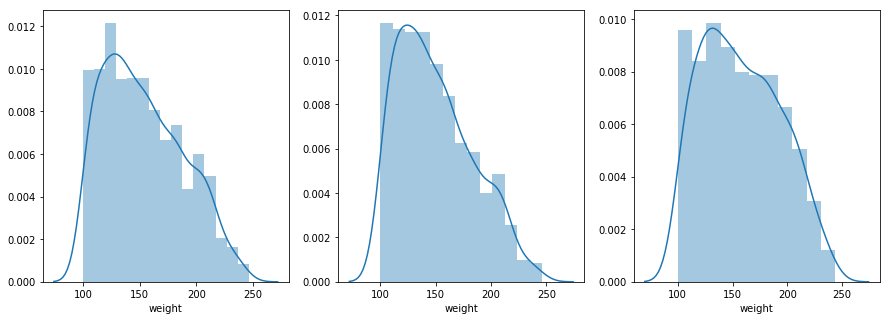

In [173]:
fig

In [174]:
#means of weight by binned age
df.groupby(['bin_age'])['weight'].mean()

bin_age
(17.938, 30.4]    149.742188
(30.4, 42.8]      147.818182
(42.8, 55.2]      150.094170
(55.2, 67.6]      158.162162
(67.6, 80.0]      162.333333
Name: weight, dtype: float64

In [175]:
df['weight'].describe()

count    1200.000000
mean      153.540833
std        35.132182
min       100.000000
25%       125.000000
50%       149.000000
75%       180.250000
max       246.000000
Name: weight, dtype: float64

In [176]:
younger_pop['weight'].describe()

count    626.000000
mean     149.426518
std       33.957506
min      100.000000
25%      122.000000
50%      143.500000
75%      172.000000
max      246.000000
Name: weight, dtype: float64

In [177]:
older_pop['weight'].describe()

count    574.000000
mean     158.027875
std       35.864822
min      100.000000
25%      127.000000
50%      154.000000
75%      184.750000
max      244.000000
Name: weight, dtype: float64

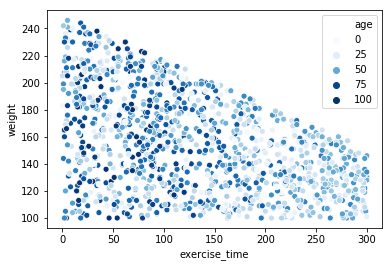

In [178]:
#correlation between exercise time and weight with a hue set on age
sns.scatterplot(df['exercise_time'], df['weight'],hue=df['age'],palette='Blues')

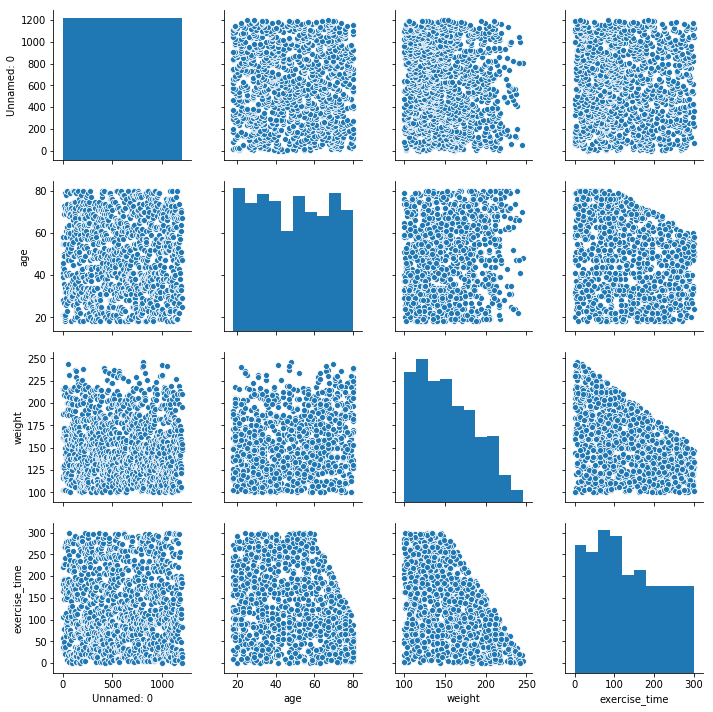

In [179]:
sns.pairplot(df)

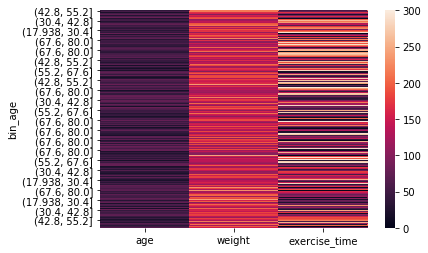

In [184]:
#not much relevant information here
df1 = df.set_index('bin_age')
sns.heatmap(df1.iloc[:,1:4])

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
age - discrete integer
weight - discrete integer
exercise_time - discrete integer

2.  What are the relationships between the variables?

age/exercise - as you age, the less you exercise
age/weight - no real correlation
exercise/weight - the more you exercise the less you weigh

From a glance, the more someone exercises the less they weigh. Although people older in age exercise less their weight is distributed similarly to the entire dataset hinting at a spurious relationship. 

3.  Which relationships are "real", and which spurious?

Tough to say, but the "real" I'd say is the more exercise you do the more likely you are to weigh less. The spurious is the older you are, the more you weigh.  

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)